In [5]:
from sklearn.datasets import make_blobs
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit.circuit.library import ZFeatureMap
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import PegasosQSVC
from qiskit_machine_learning.state_fidelities import ComputeUncompute
import matplotlib.pyplot as plt

In [2]:
#create a dataset and then divide into training and testing sets
features, labels = make_blobs(n_samples=20, n_features=2, centers=2, random_state=3, shuffle=True)

features = MinMaxScaler(feature_range=(0, np.pi)).fit_transform(features)

train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=15, shuffle=False
)

In [3]:
# number of qubits is equal to the number of features
num_qubits = 2

# number of steps performed during the training procedure
tau = 100

# regularization parameter
C = 1000

In [6]:
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)

algorithm_globals.random_seed = 12345

feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=1)

qkernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

In [7]:
pegasos_qsvc = PegasosQSVC(quantum_kernel=qkernel, C=C, num_steps=tau)

# training
pegasos_qsvc.fit(train_features, train_labels)

# testing
pegasos_score = pegasos_qsvc.score(test_features, test_labels)
print(f"PegasosQSVC classification test score: {pegasos_score}")

PegasosQSVC classification test score: 1.0


In [8]:
grid_step = 0.2
margin = 0.2
grid_x, grid_y = np.meshgrid(
    np.arange(-margin, np.pi + margin, grid_step), np.arange(-margin, np.pi + margin, grid_step)
)
meshgrid_features = np.column_stack((grid_x.ravel(), grid_y.ravel()))
meshgrid_colors = pegasos_qsvc.predict(meshgrid_features)

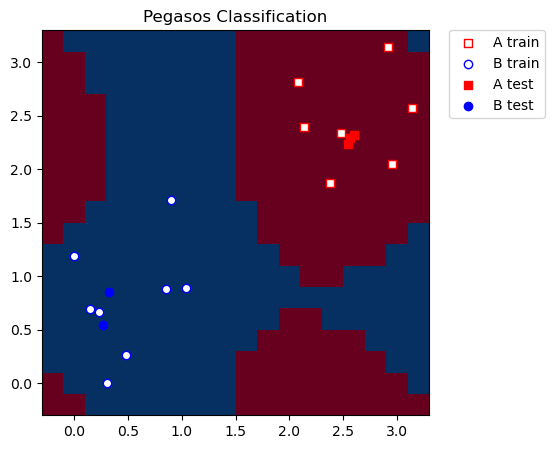

In [9]:
plt.figure(figsize=(5, 5))
meshgrid_colors = meshgrid_colors.reshape(grid_x.shape)
plt.pcolormesh(grid_x, grid_y, meshgrid_colors, cmap="RdBu", shading="auto")

plt.scatter(
    train_features[:, 0][train_labels == 0],
    train_features[:, 1][train_labels == 0],
    marker="s",
    facecolors="w",
    edgecolors="r",
    label="A train",
)
plt.scatter(
    train_features[:, 0][train_labels == 1],
    train_features[:, 1][train_labels == 1],
    marker="o",
    facecolors="w",
    edgecolors="b",
    label="B train",
)

plt.scatter(
    test_features[:, 0][test_labels == 0],
    test_features[:, 1][test_labels == 0],
    marker="s",
    facecolors="r",
    edgecolors="r",
    label="A test",
)
plt.scatter(
    test_features[:, 0][test_labels == 1],
    test_features[:, 1][test_labels == 1],
    marker="o",
    facecolors="b",
    edgecolors="b",
    label="B test",
)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Pegasos Classification")
plt.show()